[link text](https://)  
#  Exp 6 Jan23 - Regular Dataset (7 OM Combined) - Tokenization 1

## Setup

In [79]:
!pip install "tensorflow-text>=2.10"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
import numpy as np
import typing
from typing import Any, Tuple
from sklearn.model_selection import train_test_split

import pathlib

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [81]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

#### Loading the Dataset

In [82]:
import pandas as pd
ORM_data = pd.read_csv('7-om-combined-no-space-regular.csv')


In [83]:
ORM_data.head()

,OM_Regular,OM_Prediction
0,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...
1,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...
2,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...
3,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...
4,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...


In [84]:
OM_Regular = ORM_data['OM_Regular'].values
OM_Prediction = ORM_data['OM_Prediction'].values

In [85]:
X = OM_Regular
Y = OM_Prediction

#### Dividing data as Target and Context

In [86]:
target_raw =  Y
context_raw = X
print(context_raw[-1])

moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5+c3_at6id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_typeonesigc3_at6extendsc3_at6_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at3noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_type,onesigclass5_nameextendsClassattrSet=c5_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1_0+c6_at2+c

In [87]:
print(target_raw[-1])

moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5+c3_at6id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_typeonesigc3_at6extendsc3_at6_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at3noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_type,onesigclass5_nameextendsClassattrSet=c5_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1_0+c6_at2+c

### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [88]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 1

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [89]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor([b'moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1id=c1_at1isAbstract=Nonoparent}onesigc1_at1extendsc1_at1_type,onesigclass01_nameextendsClassattrSet=c01_at1id=c01_at1isAbstract=Nonoparent}onesigc01_at1extendsc01_at1_type,onesigassoc1extendsAssociationsrc=class1_namedst=class01_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass2_nameextendsClassattrSet=c2_at1id=c2_at1isAbstract=Nonoparent}onesigc2_at1extendsc2_at1_type,onesigassoc2extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1isAbstract=Nonoparent}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_type,onesigclass4_nameextendsClassattrSet=c4_at1oneparentid=c3_at1isAbstract=Noparentinclass3_name}onesigc4_at1extendsc4_at1_type,onesigassoc3extendsAssociationdst=class2_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass5_nameextendsClassatt

### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. Mainly using a `layers.TextVectorization` layer.

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation, We may or may not decide to Use this for ORM data. I kept it in the experiment

In [90]:
#example_text = tf.constant('moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,​OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc1`(`c5_at1`c5_at1_type`c1_at1`c1_at1_typeKEY`FK_assoc1_c5_at1_idx`(`c5_at1`)KEY`FK_assoc1_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c5_at1``c1_at1`));----CREATETABLE`assoc3``c5_at1`c5_at1_type`c4_at1`c4_at1_typeKEY`FK_assoc3_c5_at1_idx`(`c5_at1`)KEY`FK_assoc3_c4_at1_idx`(`c4_at1`)PRIMARYKEY(`c5_at1``c4_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type`c5_at1`c5_at1_typePRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type`c3_at1`c3_at1_typeNOTNULLPRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type`c2_at1`c2_at1_typePRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_typePRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_typePRIMARYKEY(`c1_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type`c6_at3`c6_at3_type`c6_at2`c6_at2_type`c6_at1`c6_at1_typeNOTNULLPRIMARYKEY(`c6_at1`));----CREATETABLE`assoc2`(`c5_at1`c5_at1_type`c2_at1`c2_at1_typeKEY`FK_assoc2_c5_at1_idx`(`c5_at1`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c5_at1``c2_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL`c2_at1`c2_at1_typeKEY`FK_assoc5_c3_at1_idx`(`c3_at1`)KEY`FK_assoc5_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1``c2_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL`c2_at1`c2_at1_typeKEY`FK_assoc4_c6_at1_idx`(`c6_at1`)KEY`FK_assoc4_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c6_at1``c2_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE')

example_text = tf.constant('moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1id=c1_at1isAbstract=Nonoparent}onesigc1_at1extendsc1_at1_type,onesigclass01_nameextendsClassattrSet=c01_at1id=c01_at1isAbstract=Nonoparent}onesigc01_at1extendsc01_at1_type,onesigassoc1extendsAssociationsrc=class1_namedst=class01_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass2_nameextendsClassattrSet=c2_at1id=c2_at1isAbstract=Nonoparent}onesigc2_at1extendsc2_at1_type,onesigassoc2extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1isAbstract=Nonoparent}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_type,onesigclass4_nameextendsClassattrSet=c4_at1oneparentid=c3_at1isAbstract=Noparentinclass3_name}onesigc4_at1extendsc4_at1_type,onesigassoc3extendsAssociationdst=class2_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentid=c3_at1isAbstract=Noparentinclass3_name}onesigc5_at2extendsc5_at2_typeonesigc5_at1extendsc5_at1_typeonesigassoc4extendsAssociationsrc=class01_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass6_nameextendsClassattrSet=c6_at1+c6_at2id=categoryIDisAbstract=Nonoparent}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigclass7_nameextendsClassattrSet=c7_at1+c7_at2+c7_at3+c7_at4id=c7_at1isAbstract=Nonoparent}onesigc7_at1extendsc7_at1_typeonesigc7_at2extendsc7_at2_typeonesigc7_at3extendsc7_at3_typeonesigc7_at4extendsc7_at4_typeonesigassoc5extendsAssociationsrc=class7_namesrc=class6_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc,}onesigclass8_nameextendsClassattrSet=c8_at1id=c8_at1isAbstract=Nonoparent}onesigc8_at1extendsIntegeronesigassoc6extendsAssociationsrc=class7_namedst=class8_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc7extendsAssociationsrc=class7_namedst=class3_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc,}onesigclass9_nameextendsClassattrSet=c9_at1+c10_at2oneparentid=c7_at1isAbstract=Noparentinclass7_name}onesigc9_at1extendsc9_at1_typeonesigc10_at2extendsc10_at2_typeonesigclass10_nameextendsClassattrSet=c10_at1oneparentid=c7_at1isAbstract=Noparentinclass7_name}onesigc10_at1extendsc10_at1_typeonesigclass11_nameextendsClassattrSet=c11_at1oneparentid=c7_at1isAbstract=Noparentinclass7_name}onesigc11_at1extendsstringonesigclass12_nameextendsClassattrSet=c12_at1+c12_at2+c12_at3id=c12_at1isAbstract=Nonoparent}onesigc12_at1extendsc12_at1_typeonesigc12_at2extendsc12_at2_typeonesigc12_at3extendsc12_at3_typeonesigassoc8extendsAssociationsrc=class7_namesrc=class12_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc,}onesigclass13_nameextendsClassattrSet=c13_at1oneparentid=c12_at1isAbstract=Noparentinclass12_name}onesigc13_at1extendsc13_at1_typeonesigclass14_nameextendsClassattrSet=c14_at1oneparentid=c12_at1isAbstract=Noparentinclass12_name}onesigc14_at1extendsc14_at1_typepredshowrunshow,TableName:class1_nameTableName:class01_nameTableNameclass2_nameTableNameclass3_nameTableNameclass4_nameTableNameclass5_nameTableNameassoc7TableNameassoc5TableNameclass8_nameTableNameclass6_nameTableNameclass10_nameMappingStrategyforclass1_name:map_str2MappingStrategyforclass6_name:map_str2MappingStrategyforclass4_name:map_str3MappingStrategyforclass3_name:map_str3MappingStrategyforclass7_name:map_str1MappingStrategyforclass9_name:map_str1MappingStrategyforclass10_name:map_str1MappingStrategyforclass11_name:map_str1MappingStrategyforclass12_name:map_str1MappingStrategyforclass11_name:map_str1MappingStrategyforclass14_name:map_str1AssociationStrategyforassoc1:assoc_str1AssociationStrategyforassoc2:assoc_str1AssociationStrategyforassoc3:assoc_str1AssociationStrategyforassoc4:assoc_str1AssociationStrategyforassoc5:assoc_str2AssociationStrategyforassoc6:assoc_str2AssociationStrategyforassoc7:assoc_str2AssociationStrategyforassoc8:assoc_str2,USEOM_name_0CREATETABLE`class01_name`(`c01_at1`c01_at1_typeNOTNULL,`c1_at1`c1_at1_type,KEY`FK_class01_name_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c01_at1`),);CREATETABLE`class6_name`(`c7_at1`c7_at1_type(64)`c6_at1`c6_at1_typeNOTNULLPRIMARYKEY(`c6_at1`),);CREATETABLE`class1_name`(`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`),);CREATETABLE`ShippingCartItemAssociation`(`c3_at1`c3_at1_typeNOTNULL`c2_at1`c2_at1_typeNOTNULLKEY`FK_ShippingCartItemAssociation_ItemID_idx`(`ItemID`),KEY`FK_ShippingCartItemAssociation_shippingCartID_idx`(`shippingCartID`),PRIMARYKEY(`ItemID`,`shippingCartID`));CREATETABLE`class7_name`(`DType`varchar(64),`c10_at2`c10_at2_type,`c11_at1`c11_at1_type(64)`c10_at1`c10_at1_type(64)`c7_at3`c7_at3_type(64)`c7_at2`c7_at2_type`c9_at1`c9_at1_type(20,5),`c7_at4`c7_at4_type(20,5)`c7_at1`c7_at1_typeNOTNULLPRIMARYKEY(`c7_at1`),);CREATETABLE`class2_name`(`c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`c2_at1`),);CREATETABLE`class8_name`(`c8_at1`c8_at1_typeNOTNULL`c7_at1`c7_at1_typeKEY`FK_class8_name_c7_at1_idx`(`c7_at1`)PRIMARYKEY(`c8_at1`),);CREATETABLE`assoc7`(`c7_at1`c7_at1_typeNOTNULL`c3_at1`c3_at1_typeNOTNULLKEY`FK_assoc7_c7_at1_idx`(`c7_at1`)KEY`FK_assoc7_c3_at1_idx`(`c3_at1`)PRIMARYKEY(`c7_at1`,`c3_at1`),);CREATETABLE`class3_name`(`DType`varchar(64),`c5_at1`c5_at1_type,`c5_at2`c5_at2_type,`c4_at1`c4_at1_type,`c3_at2`c3_at2_type`c3_at1`c3_at1_typeNOTNULLPRIMARYKEY(`c3_at1`),);CREATETABLE`CustomerShippingCartAssociation`(`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_typeNOTNULLKEY`FK_CustomerShippingCartAssociation_shippingCartID_idx`(`shippingCartID`),KEY`FK_CustomerShippingCartAssociation_customerID_idx`(`customerID`),PRIMARYKEY(`shippingCartID`,`customerID`));CREATETABLE`assoc8`(`c12_at1`c12_at1_typeNOTNULL`c7_at1`c7_at1_typeNOTNULLKEY`FK_assoc8_c12_at1_idx`(`c12_at1`)KEY`FK_assoc8_c7_at1_idx`(`c7_at1`)PRIMARYKEY(`c12_at1`,`c7_at1`),);CREATETABLE`class12_name`(`DType`varchar(64),`c14_at1`c14_at1_type(64)`c12_at3`c12_at3_type(64)`c12_at2`c12_at2_type(64)`c13_at1`c13_at1_type(64)`c12_at1`c12_at1_typeNOTNULLPRIMARYKEY(`c12_at1`),);CREATETABLE`OrderItemAssociation`(`c3_at1`c3_at1_typeNOTNULL`c01_at1`c01_at1_typeNOTNULL,KEY`FK_OrderItemAssociation_ItemID_idx`(`ItemID`),KEY`FK_OrderItemAssociation_orderID_idx`(`orderID`),PRIMARYKEY(`ItemID`,`orderID`));CREATETABLE`assoc5`(`c7_at1`c7_at1_typeNOTNULL`c6_at1`c6_at1_typeNOTNULLKEY`FK_assoc5_c7_at1_idx`(`c7_at1`)KEY`FK_assoc5_c6_at1_idx`(`c6_at1`)PRIMARYKEY(`c7_at1`,`c6_at1`),);ALTERTABLE`class01_name`ADDCONSTRAINT`FK_class01_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`ShippingCartItemAssociation`ADDCONSTRAINT`FK_ShippingCartItemAssociation_ItemID`FOREIGNKEY(`ItemID`)REFERENCES`Item`(`ItemID`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_ShippingCartItemAssociation_shippingCartID`FOREIGNKEY(`shippingCartID`)REFERENCES`ShippingCart`(`shippingCartID`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class8_name`ADDCONSTRAINT`FK_class8_name_c7_at1`FOREIGNKEY(`c7_at1`)REFERENCES`class7_name`(`c7_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc7`ADDCONSTRAINT`FK_assoc7_c7_at1`FOREIGNKEY(`c7_at1`)REFERENCES`class7_name`(`c7_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc7_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`CustomerShippingCartAssociation`ADDCONSTRAINT`FK_CustomerShippingCartAssociation_shippingCartID`FOREIGNKEY(`shippingCartID`)REFERENCES`ShippingCart`(`shippingCartID`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_CustomerShippingCartAssociation_customerID`FOREIGNKEY(`customerID`)REFERENCES`Customer`(`customerID`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc8`ADDCONSTRAINTFK_assoc5_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINTFK_assoc8_c7_at1`FOREIGNKEY(`c7_at1`)REFERENCES`class7_name`(`c7_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`OrderItemAssociation`ADDCONSTRAINT`FK_OrderItemAssociation_ItemID`FOREIGNKEY(`ItemID`)REFERENCES`Item`(`ItemID`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_OrderItemAssociation_orderID`FOREIGNKEY(`orderID`)REFERENCES`Order`(`orderID`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c7_at1`FOREIGNKEY(`c7_at1`)REFERENCES`class7_name`(`c7_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINTFK_assoc5_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE')
print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1id=c1_at1isAbstract=Nonoparent}onesigc1_at1extendsc1_at1_type,onesigclass01_nameextendsClassattrSet=c01_at1id=c01_at1isAbstract=Nonoparent}onesigc01_at1extendsc01_at1_type,onesigassoc1extendsAssociationsrc=class1_namedst=class01_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass2_nameextendsClassattrSet=c2_at1id=c2_at1isAbstract=Nonoparent}onesigc2_at1extendsc2_at1_type,onesigassoc2extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1isAbstract=Nonoparent}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_type,onesigclass4_nameextendsClassattrSet=c4_at1oneparentid=c3_at1isAbstract=Noparentinclass3_name}onesigc4_at1extendsc4_at1_type,onesigassoc3extendsAssociationdst=class2_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass5_nameextendsClassattrSet=c5_at1

In [91]:
#import re


def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a[^0-9.,]-z[^0-9.,]./[^0-9.,]+/?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text


In [92]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1id=c1_at1isAbstract=Nonoparent}onesigc1_at1extendsc1_at1_type,onesigclass01_nameextendsClassattrSet=c01_at1id=c01_at1isAbstract=Nonoparent}onesigc01_at1extendsc01_at1_type,onesigassoc1extendsAssociationsrc=class1_namedst=class01_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass2_nameextendsClassattrSet=c2_at1id=c2_at1isAbstract=Nonoparent}onesigc2_at1extendsc2_at1_type,onesigassoc2extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1isAbstract=Nonoparent}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_type,onesigclass4_nameextendsClassattrSet=c4_at1oneparentid=c3_at1isAbstract=Noparentinclass3_name}onesigc4_at1extendsc4_at1_type,onesigassoc3extendsAssociationdst=class2_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass5_nameextendsClassattrSet=c5_at1+c

#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [93]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [94]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:100]

['',
 '[UNK]',
 ',',
 'src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc',
 '[START]',
 '[END]',
 '5)`c7_at1`c7_at1_typenotnullprimarykey(`c7_at1`)',
 'moduleom_name:0',
 'src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2',
 '`c3_at1`)',
 ');createtable`class5_name`(`c5_at1`c5_at1_type',
 '`c5_at2`c5_at2_type',
 '`c2_at1`)',
 '}onesigclass9_nameextendsclassattrset=c9_at1+c10_at2oneparentid=c7_at1isabstract=noparentinclass7_name}onesigc9_at1extendsc9_at1_typeonesigc10_at2extendsc10_at2_typeonesigclass10_nameextendsclassattrset=c10_at1oneparentid=c7_at1isabstract=noparentinclass7_name}onesigc10_at1extendsc10_at1_typeonesigclass11_nameextendsclassattrset=c11_at1oneparentid=c7_at1isabstract=noparentinclass7_name}onesigc11_at1extendsstringonesigclass12_nameextendsclassattrset=c12_at1+c12_at2+c12_at3id=c12_at1isabstract=nonoparent}onesigc12_at1extendsc12_at1_typeonesigc12_at2extendsc12_at2_typeonesigc12_at3extendsc12_at3_typeonesigassoc8extendsassociationsrc=class7_namesrc=class12_namesrc

That's the context data  `TextVectorization` layer, now build and `.adapt()` for the Target Data one:

In [95]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:100]

['',
 '[UNK]',
 ',',
 'src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc',
 '[START]',
 '[END]',
 '5)`c7_at1`c7_at1_typenotnullprimarykey(`c7_at1`)',
 'moduleom_name:0',
 'p',
 'src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2',
 '`c3_at1`)',
 ');createtable`class5_name`(`c5_at1`c5_at1_type',
 'np',
 '`c5_at2`c5_at2_type',
 '`c2_at1`)',
 '}onesigclass9_nameextendsclassattrset=c9_at1+c10_at2oneparentid=c7_at1isabstract=noparentinclass7_name}onesigc9_at1extendsc9_at1_typeonesigc10_at2extendsc10_at2_typeonesigclass10_nameextendsclassattrset=c10_at1oneparentid=c7_at1isabstract=noparentinclass7_name}onesigc10_at1extendsc10_at1_typeonesigclass11_nameextendsclassattrset=c11_at1oneparentid=c7_at1isabstract=noparentinclass7_name}onesigc11_at1extendsstringonesigclass12_nameextendsclassattrset=c12_at1+c12_at2+c12_at3id=c12_at1isabstract=nonoparent}onesigc12_at1extendsc12_at1_typeonesigc12_at2extendsc12_at2_typeonesigc12_at3extendsc12_at3_typeonesigassoc8extendsassociationsrc=class7_namesrc=cl

Now these layers can convert a batch of strings into a batch of token IDs:

In [96]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[4, 7, 2, 21, 2, 23, 2, 26, 2, 18, 2, 25, 2, 17, 2, 22, 2, 24, 2, 16, 2,
  15, 2, 14, 2, 20, 2, 13, 2, 19, 2, 387, 2, 37, 2, 36, 2, 45, 2, 27, 2,
  33, 2, 34, 2, 61, 2, 47, 2, 6, 2, 164, 2, 6, 2, 44, 2, 72, 2, 69, 2, 49,
  2, 39, 2, 38, 2, 51, 2, 35, 2, 9, 2, 59, 2, 157, 2, 6, 2, 46, 2, 121, 2,
  32, 2, 122, 2, 119, 2, 10, 2, 11, 2, 103, 2, 40, 2, 30, 2, 105, 2, 41,
  2, 64, 2, 31, 2, 225, 2, 65, 2, 60, 2, 28, 2, 57, 2, 120, 2, 102, 2, 48,
  2, 29, 2, 104, 2, 63, 5]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [97]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] moduleom_name:0 , opendeclarationonesigclass1_nameextendsclassattrset=c1_at1id=c1_at1isabstract=nonoparent}onesigc1_at1extendsc1_at1_type , onesigclass01_nameextendsclassattrset=c01_at1id=c01_at1isabstract=nonoparent}onesigc01_at1extendsc01_at1_type , onesigassoc1extendsassociationsrc=class1_namedst=class01_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc , }onesigclass2_nameextendsclassattrset=c2_at1id=c2_at1isabstract=nonoparent}onesigc2_at1extendsc2_at1_type , onesigassoc2extendsassociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc , }onesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1isabstract=nonoparent}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_type , onesigclass4_nameextendsclassattrset=c4_at1oneparentid=c3_at1isabstract=noparentinclass3_name}onesigc4_at1extendsc4_at1_type , onesigassoc3extendsassociationdst=class2_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc , }onesigclass5_namee

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

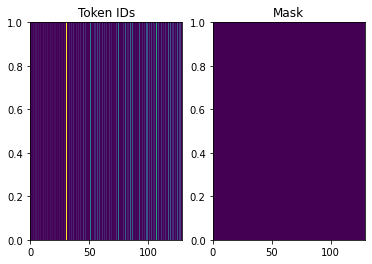

In [98]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [99]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [100]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  4 299   2 300 256 278   2 386   2  36]

[  4 300   2 301 268 278   2 390   2  38]
[300   2 301 268 278   2 390   2  38   2]


## The encoder/decoder

  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [101]:
UNITS = 256

### The encoder


The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [102]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [103]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (1, 85)
Encoder output, shape (batch, s, units): (1, 85, 256)


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output. 


In [104]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [107]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (1, 85, 256)
Target sequence, shape (batch, t, units): (1, 86, 256)
Attention result, shape (batch, t, units): (1, 86, 256)
Attention weights, shape (batch, t, s):    (1, 86, 85)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [108]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.0000001 , 0.99999994, 1.        , 0.9999999 , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 0.9999999 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.9999999 , 1.        , 1.0000001 , 1.        ,
       0.99999994, 1.        , 1.0000001 , 1.        , 0.9999999 ,
       1.        , 0.9999999 , 1.        , 0.99999994, 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 0.9999999 , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 0.9999999 , 1.        , 0.99999994,
       1.        , 0.99999994, 1.        , 0.9999999 , 1.     



Here are the attention weights across the context sequences at `t=0`:

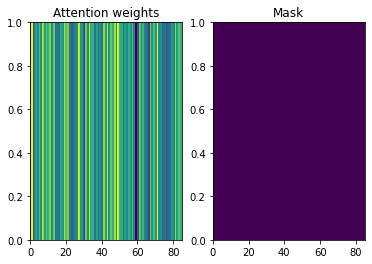

In [109]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.


Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [110]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state. 

In [111]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [112]:
decoder = Decoder(target_text_processor, UNITS)

Decoder usage

In [113]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (1, 85, 256)
input target tokens shape: (batch, t) (1, 86)
logits shape shape: (batch, target_vocabulary_size) (1, 86, 781)


#### Inference

For inference usage couple more methods.

In [114]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [115]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [116]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

With those extra functions, you can write a generation loop:

In [117]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'createtable`assoc10`(c3_at1`c3_at1_typenotnullc2_at1`c2_at1_typenotnullkey`fk_assoc10_c3_at1_idx`(`c3_at1`)key`fk_assoc10_c2_at1_idx`(`c2_at1`)primarykey(`c3_at1` primarykey(`c3_at1`));createtable`class5_name`(`c4_at2`c4_at2_type(64) tablename:class1_nametablename:class01_nametablenameclass2_namemappingstrategyforclass1_name:map_str2mappingstrategyforclass6_name:map_str2mappingstrategyforclass7_name:map_str2mappingstrategyforclass12_name:map_str2mappingstrategyforclass4_name:map_str3mappingstrategyforclass3_name:map_str3mappingstrategyforclass9_name:map_str3mappingstrategyforclass10_name:map_str3mappingstrategyforclass11_name:map_str3mappingstrategyforclass11_name:map_str3mappingstrategyforclass14_name:map_str3associationstrategyforassoc1:assoc_str1associationstrategyforassoc2:assoc_str1associationstrategyforassoc4:assoc_str1associationstrategyforassoc6:assoc_str1associationstrategyforassoc3:assoc_str2associationstrategyforassoc5:assoc_str2associationstrategyforassoc7:assoc_st



```
# This is formatted as code
```

**Since the model's untrained, it outputs items from the vocabulary almost uniformly at random. **

## The model


In [118]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [119]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (1, 85)
Target tokens, shape: (batch, t) (1, 86)
logits, shape: (batch, t, target_vocabulary_size) (1, 86, 781)


### Train

For training, you'll want to implement your own masked loss and accuracy functions:

In [120]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [121]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [122]:
model.compile(optimizer='RMSProp',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [123]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 6.660575, 'expected_acc': 0.0012804097311139564}

That should roughly match the values returned by running a few steps of evaluation:

In [124]:
model.evaluate(val_ds, steps=30, return_dict=True)

30/30 [==============================] - 8s 21ms/step - loss: 6.7361 - masked_acc: 0.0000e+00 - masked_loss: 6.7361


{'loss': 6.736114501953125,
 'masked_acc': 0.0,
 'masked_loss': 6.736114501953125}

In [125]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 30,
    validation_data=val_ds,
    validation_steps = 80,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=4)])

Epoch 1/100
30/30 [==============================] - 22s 287ms/step - loss: 3.5580 - masked_acc: 0.4751 - masked_loss: 3.5580 - val_loss: 2.9957 - val_masked_acc: 0.5114 - val_masked_loss: 2.9957
Epoch 2/100
30/30 [==============================] - 4s 136ms/step - loss: 2.5812 - masked_acc: 0.5926 - masked_loss: 2.5812 - val_loss: 2.4688 - val_masked_acc: 0.6387 - val_masked_loss: 2.4688
Epoch 3/100
30/30 [==============================] - 4s 152ms/step - loss: 2.0302 - masked_acc: 0.7098 - masked_loss: 2.0302 - val_loss: 1.8464 - val_masked_acc: 0.6957 - val_masked_loss: 1.8464
Epoch 4/100
30/30 [==============================] - 4s 138ms/step - loss: 1.5400 - masked_acc: 0.7535 - masked_loss: 1.5400 - val_loss: 1.2929 - val_masked_acc: 0.7908 - val_masked_loss: 1.2929
Epoch 5/100
30/30 [==============================] - 4s 148ms/step - loss: 1.3057 - masked_acc: 0.7947 - masked_loss: 1.3057 - val_loss: 1.0504 - val_masked_acc: 0.8263 - val_masked_loss: 1.0504
Epoch 6/100
30/30 [=====

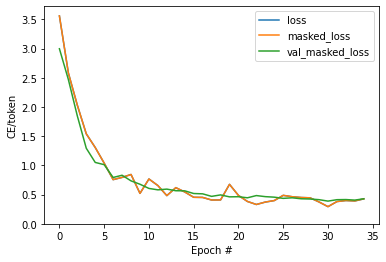

In [126]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['masked_loss'], label='masked_loss')
plt.plot(history.history['val_masked_loss'], label='val_masked_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

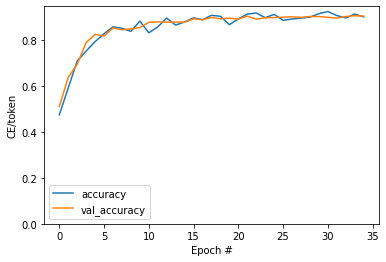

In [127]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights.

In [128]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [129]:
#sample Dataset Library_Management_Dataset_1_input_prerp_each_class_and_entitities_sep_experiment 

result1 = model.translate(['moduleOM:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5+c3_at6id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_typeonesigc3_at6extendsc3_at6_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at3noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_type,onesigclass5_nameextendsClassattrSet=c5_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1_0+c6_at2+c6_at3+c6_at4id=c6_at2noparentisAbstract=No}onesigc6_at1_0extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_type,onesigclass7_nameextendsClassattrSet=c7_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc7_at1extendsc7_at1_type,onesigclass8_nameextendsClassattrSet=c8_at1+c8_at2+c2_at2+c6_at3id=c8_at1noparentisAbstract=No}onesigc8_at1extendsc8_at1_typeonesigc8_at1extendsc8_at1_type,onesigassoc1extendsAssociationsrc=class8_namedst=class2_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc2extendsAssociationsrc=class2_namedst=class4_name,src_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc,}onesigassoc3extendsAssociationsrc=class8_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc4extendsAssociationsrc=class8_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc5extendsAssociationsrc=class8_namedst=class6_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc6extendsAssociationsrc=class6_namedst=class1_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc7extendsAssociationsrc=class6_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc8extendsAssociationsrc=class1_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc9extendsAssociationsrc=class1_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc10extendsAssociationsrc=class2_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2, MappingStrategyforclass1_name:map_str2MappingStrategyforclass5_name:map_str3MappingStrategyforclass7_name:map_str3AssociationStrategyforassoc1:assoc_str1AssociationStrategyforassoc3:assoc_str1AssociationStrategyforassoc4:assoc_str1AssociationStrategyforassoc7:assoc_str1AssociationStrategyforassoc8:assoc_str1AssociationStrategyforassoc9:assoc_str1AssociationStrategyforassoc10:assoc_str2AssociationStrategyforassoc5:assoc_str2AssociationStrategyforassoc6:assoc_str2, USEOM_name_0CREATETABLE`class3_name`(`c8_at1`c8_at1_type`c3_at6`c3_at6_type`c3_at5`c3_at5_type`c3_at4`c3_at4_type`c3_at3`c3_at3_type`c3_at2`c3_at2_typec3_at1`c3_at1_typeNOTNULLc1_at1`c1_at1_typeKEY`FK_class3_name_c8_at1_idx`(`c8_at1`)KEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c3_at1`),CREATETABLE`class1_name`(`c1_at1`c1_at2_type(64)`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`),CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64)`c8_at1`c8_at1_typec2_at1`c2_at1_typeNOTNULLKEY`FK_class2_name_c8_at1_idx`(`c8_at1`)PRIMARYKEY(`c1_at1`),CREATETABLE`class7_name`(`c7_at1`c7_at1_type(64)c2_at1`c2_at1_typeNOTNULLKEY`FK_class7_name_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c1_at1`),CREATETABLE`assoc10`(c3_at1`c3_at1_typeNOTNULLc2_at1`c2_at1_typeNOTNULLKEY`FK_assoc10_c3_at1_idx`(`c3_at1`)KEY`FK_assoc10_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1`,`c2_at1`),CREATETABLE`class8_name`(`c8_at2`c8_at2_type(64)`c6_at3`c6_at3_type(64)``c8_at1`c8_at1_typeNOTNULLPRIMARYKEY(`c8_at1`),CREATETABLE`class5_name`(`c5_at1`c5_at1_type,c2_at1`c2_at1_typeNOTNULLKEY`FK_class5_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c1_at1`),CREATETABLE`assoc5`(``c8_at1`c8_at1_typeNOTNULL`c2_at1`c2_at1_typeNOTNULLKEY`FK_assoc5_c8_at1_idx`(`c8_at1`),KEY`FK_assoc5_c6_at2_idx`(`c6_at2`)PRIMARYKEY(`c8_at1`,`c6_at2`),CREATETABLE`class4_name`(`c4_at4`c4_at4_type(64)`c4_at2`c4_at2_type(64)`c4_at1`c4_at1_type(64)`c8_at1`c8_at1_type`c6_at2`c6_at2_type`c4_at3`c4_at3_typec1_at1`c1_at1_typeKEY`FK_class4_name_c8_at1_idx`(`c8_at1`)KEY`FK_class4_name_c6_at2_idx`(`c6_at2`)KEY`FK_class4_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c4_at3`),CREATETABLE`assoc6`(`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_typeNOTNULL`c3_at1`c3_at1_typeNOTNULLKEY`FK_assoc6_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c6_at2`,`c1_at1`),CREATETABLE`class6_name`(`c6_at4`c6_at4_type(64)`c6_at1_0`c6_at1_type`c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`c6_at2`),CREATETABLE`assoc2`(`c4_at3`c4_at3_typec2_at1`c2_at1_typeNOTNULLKEY`FK_assoc2_c4_at3_idx`(`c4_at3`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c4_at3`,`c2_at1`),ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`class7_name`ADDCONSTRAINT`FK_class2_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc10`ADDCONSTRAINT`FK_assoc10_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc10_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class5_nameADDCONSTRAINT`FK_class5_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class4_name`ADDCONSTRAINT`FK_class4_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c6_at2`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc6`ADDCONSTRAINT`FK_assoc6_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc6_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c4_at3`FOREIGNKEY(`c4_at3`)REFERENCES`class4_name`(`c4_at3`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE']) 
result2 = model.translate(['moduleOM:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5+c3_at6id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_typeonesigc3_at6extendsc3_at6_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at3noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_type,onesigclass5_nameextendsClassattrSet=c5_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1_0+c6_at2+c6_at3+c6_at4id=c6_at2noparentisAbstract=No}onesigc6_at1_0extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_type,onesigclass7_nameextendsClassattrSet=c7_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc7_at1extendsc7_at1_type,onesigclass8_nameextendsClassattrSet=c8_at1+c8_at2+c2_at2+c6_at3id=c8_at1noparentisAbstract=No}onesigc8_at1extendsc8_at1_typeonesigc8_at1extendsc8_at1_type,onesigassoc1extendsAssociationsrc=class8_namedst=class2_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc2extendsAssociationsrc=class2_namedst=class4_name,src_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc,}onesigassoc3extendsAssociationsrc=class8_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc4extendsAssociationsrc=class8_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc5extendsAssociationsrc=class8_namedst=class6_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc6extendsAssociationsrc=class6_namedst=class1_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc7extendsAssociationsrc=class6_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc8extendsAssociationsrc=class1_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc9extendsAssociationsrc=class1_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc10extendsAssociationsrc=class2_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2, MappingStrategyforclass1_name:map_str2MappingStrategyforclass5_name:map_str3MappingStrategyforclass7_name:map_str3AssociationStrategyforassoc1:assoc_str1AssociationStrategyforassoc3:assoc_str1AssociationStrategyforassoc4:assoc_str1AssociationStrategyforassoc7:assoc_str1AssociationStrategyforassoc8:assoc_str1AssociationStrategyforassoc9:assoc_str1AssociationStrategyforassoc10:assoc_str2AssociationStrategyforassoc5:assoc_str2AssociationStrategyforassoc6:assoc_str2, USEOM_name_0CREATETABLE`class3_name`(`c8_at1`c8_at1_type`c3_at6`c3_at6_type`c3_at5`c3_at5_type`c3_at4`c3_at4_type`c3_at3`c3_at3_type`c3_at2`c3_at2_typec3_at1`c3_at1_typeNOTNULLc1_at1`c1_at1_typeKEY`FK_class3_name_c8_at1_idx`(`c8_at1`)KEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c3_at1`),CREATETABLE`class1_name`(`c1_at1`c1_at2_type(64)`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`),CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64)`c8_at1`c8_at1_typec2_at1`c2_at1_typeNOTNULLKEY`FK_class2_name_c8_at1_idx`(`c8_at1`)PRIMARYKEY(`c1_at1`),CREATETABLE`class7_name`(`c7_at1`c7_at1_type(64)c2_at1`c2_at1_typeNOTNULLKEY`FK_class7_name_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c1_at1`),CREATETABLE`assoc10`(c3_at1`c3_at1_typeNOTNULLc2_at1`c2_at1_typeNOTNULLKEY`FK_assoc10_c3_at1_idx`(`c3_at1`)KEY`FK_assoc10_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1`,`c2_at1`),CREATETABLE`class8_name`(`c8_at2`c8_at2_type(64)`c6_at3`c6_at3_type(64)``c8_at1`c8_at1_typeNOTNULLPRIMARYKEY(`c8_at1`),CREATETABLE`class5_name`(`c5_at1`c5_at1_type,c2_at1`c2_at1_typeNOTNULLKEY`FK_class5_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c1_at1`),CREATETABLE`assoc5`(``c8_at1`c8_at1_typeNOTNULL`c2_at1`c2_at1_typeNOTNULLKEY`FK_assoc5_c8_at1_idx`(`c8_at1`),KEY`FK_assoc5_c6_at2_idx`(`c6_at2`)PRIMARYKEY(`c8_at1`,`c6_at2`),CREATETABLE`class4_name`(`c4_at4`c4_at4_type(64)`c4_at2`c4_at2_type(64)`c4_at1`c4_at1_type(64)`c8_at1`c8_at1_type`c6_at2`c6_at2_type`c4_at3`c4_at3_typec1_at1`c1_at1_typeKEY`FK_class4_name_c8_at1_idx`(`c8_at1`)KEY`FK_class4_name_c6_at2_idx`(`c6_at2`)KEY`FK_class4_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c4_at3`),CREATETABLE`assoc6`(`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_typeNOTNULL`c3_at1`c3_at1_typeNOTNULLKEY`FK_assoc6_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c6_at2`,`c1_at1`),CREATETABLE`class6_name`(`c6_at4`c6_at4_type(64)`c6_at1_0`c6_at1_type`c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`c6_at2`),CREATETABLE`assoc2`(`c4_at3`c4_at3_typec2_at1`c2_at1_typeNOTNULLKEY`FK_assoc2_c4_at3_idx`(`c4_at3`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c4_at3`,`c2_at1`),ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`class7_name`ADDCONSTRAINT`FK_class2_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc10`ADDCONSTRAINT`FK_assoc10_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc10_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class5_nameADDCONSTRAINT`FK_class5_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class4_name`ADDCONSTRAINT`FK_class4_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c6_at2`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc6`ADDCONSTRAINT`FK_assoc6_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc6_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c4_at3`FOREIGNKEY(`c4_at3`)REFERENCES`class4_name`(`c4_at3`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result3 = model.translate(['moduleOM:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5+c3_at6id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_typeonesigc3_at6extendsc3_at6_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at3noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_type,onesigclass5_nameextendsClassattrSet=c5_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1_0+c6_at2+c6_at3+c6_at4id=c6_at2noparentisAbstract=No}onesigc6_at1_0extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_type,onesigclass7_nameextendsClassattrSet=c7_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc7_at1extendsc7_at1_type,onesigclass8_nameextendsClassattrSet=c8_at1+c8_at2+c2_at2+c6_at3id=c8_at1noparentisAbstract=No}onesigc8_at1extendsc8_at1_typeonesigc8_at1extendsc8_at1_type,onesigassoc1extendsAssociationsrc=class8_namedst=class2_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc2extendsAssociationsrc=class2_namedst=class4_name,src_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc,}onesigassoc3extendsAssociationsrc=class8_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc4extendsAssociationsrc=class8_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc5extendsAssociationsrc=class8_namedst=class6_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc6extendsAssociationsrc=class6_namedst=class1_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc7extendsAssociationsrc=class6_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc8extendsAssociationsrc=class1_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc9extendsAssociationsrc=class1_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc10extendsAssociationsrc=class2_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2, MappingStrategyforclass1_name:map_str2MappingStrategyforclass7_name:map_str2MappingStrategyforclass5_name:map_str3AssociationStrategyforassoc1:assoc_str1AssociationStrategyforassoc3:assoc_str1AssociationStrategyforassoc4:assoc_str1AssociationStrategyforassoc7:assoc_str1AssociationStrategyforassoc8:assoc_str1AssociationStrategyforassoc9:assoc_str1AssociationStrategyforassoc10:assoc_str2AssociationStrategyforassoc5:assoc_str2AssociationStrategyforassoc6:assoc_str2, USEOM_name_0CREATETABLE`class3_name`(`c8_at1`c8_at1_type`c3_at6`c3_at6_type`c3_at5`c3_at5_type`c3_at4`c3_at4_type`c3_at3`c3_at3_type`c3_at2`c3_at2_typec3_at1`c3_at1_typeNOTNULLc1_at1`c1_at1_typeKEY`FK_class3_name_c8_at1_idx`(`c8_at1`)KEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c3_at1`),CREATETABLE`class1_name`(`c1_at1`c1_at2_type(64)`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`),CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64)`c8_at1`c8_at1_typec2_at1`c2_at1_typeNOTNULLKEY`FK_class2_name_c8_at1_idx`(`c8_at1`)PRIMARYKEY(`c1_at1`),CREATETABLE`class7_name`(`c7_at1`c7_at1_type(64)c2_at1`c2_at1_typeNOTNULLKEY`FK_class7_name_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c1_at1`),CREATETABLE`assoc10`(c3_at1`c3_at1_typeNOTNULLc2_at1`c2_at1_typeNOTNULLKEY`FK_assoc10_c3_at1_idx`(`c3_at1`)KEY`FK_assoc10_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1`,`c2_at1`),CREATETABLE`class8_name`(`c8_at2`c8_at2_type(64)`c6_at3`c6_at3_type(64)``c8_at1`c8_at1_typeNOTNULLPRIMARYKEY(`c8_at1`),CREATETABLE`class5_name`(`c5_at1`c5_at1_type,c2_at1`c2_at1_typeNOTNULLKEY`FK_class5_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c1_at1`),CREATETABLE`assoc5`(``c8_at1`c8_at1_typeNOTNULL`c2_at1`c2_at1_typeNOTNULLKEY`FK_assoc5_c8_at1_idx`(`c8_at1`),KEY`FK_assoc5_c6_at2_idx`(`c6_at2`)PRIMARYKEY(`c8_at1`,`c6_at2`),CREATETABLE`class4_name`(`c4_at4`c4_at4_type(64)`c4_at2`c4_at2_type(64)`c4_at1`c4_at1_type(64)`c8_at1`c8_at1_type`c6_at2`c6_at2_type`c4_at3`c4_at3_typec1_at1`c1_at1_typeKEY`FK_class4_name_c8_at1_idx`(`c8_at1`)KEY`FK_class4_name_c6_at2_idx`(`c6_at2`)KEY`FK_class4_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c4_at3`),CREATETABLE`assoc6`(`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_typeNOTNULL`c3_at1`c3_at1_typeNOTNULLKEY`FK_assoc6_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c6_at2`,`c1_at1`),CREATETABLE`class6_name`(`c6_at4`c6_at4_type(64)`c6_at1_0`c6_at1_type`c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`c6_at2`),CREATETABLE`assoc2`(`c4_at3`c4_at3_typec2_at1`c2_at1_typeNOTNULLKEY`FK_assoc2_c4_at3_idx`(`c4_at3`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c4_at3`,`c2_at1`),ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`class7_name`ADDCONSTRAINT`FK_class2_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc10`ADDCONSTRAINT`FK_assoc10_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc10_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class5_nameADDCONSTRAINT`FK_class5_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class4_name`ADDCONSTRAINT`FK_class4_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c6_at2`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc6`ADDCONSTRAINT`FK_assoc6_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc6_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c4_at3`FOREIGNKEY(`c4_at3`)REFERENCES`class4_name`(`c4_at3`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result5 = model.translate(['moduleOM:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5+c3_at6id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_typeonesigc3_at6extendsc3_at6_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at3noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_type,onesigclass5_nameextendsClassattrSet=c5_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1_0+c6_at2+c6_at3+c6_at4id=c6_at2noparentisAbstract=No}onesigc6_at1_0extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_type,onesigclass7_nameextendsClassattrSet=c7_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc7_at1extendsc7_at1_type,onesigclass8_nameextendsClassattrSet=c8_at1+c8_at2+c2_at2+c6_at3id=c8_at1noparentisAbstract=No}onesigc8_at1extendsc8_at1_typeonesigc8_at1extendsc8_at1_type,onesigassoc1extendsAssociationsrc=class8_namedst=class2_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc2extendsAssociationsrc=class2_namedst=class4_name,src_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc,}onesigassoc3extendsAssociationsrc=class8_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc4extendsAssociationsrc=class8_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc5extendsAssociationsrc=class8_namedst=class6_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc6extendsAssociationsrc=class6_namedst=class1_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc7extendsAssociationsrc=class6_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc8extendsAssociationsrc=class1_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc9extendsAssociationsrc=class1_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc10extendsAssociationsrc=class2_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2, MappingStrategyforclass1_name:map_str2MappingStrategyforclass8_name:map_str2MappingStrategyforclass5_name:map_str3MappingStrategyforclass7_name:map_str3AssociationStrategyforassoc1:assoc_str1AssociationStrategyforassoc3:assoc_str1AssociationStrategyforassoc4:assoc_str1AssociationStrategyforassoc7:assoc_str1AssociationStrategyforassoc8:assoc_str1AssociationStrategyforassoc9:assoc_str1AssociationStrategyforassoc10:assoc_str2AssociationStrategyforassoc5:assoc_str2AssociationStrategyforassoc6:assoc_str2, USEOM_name_0CREATETABLE`class3_name`(`c8_at1`c8_at1_type`c3_at6`c3_at6_type`c3_at5`c3_at5_type`c3_at4`c3_at4_type`c3_at3`c3_at3_type`c3_at2`c3_at2_typec3_at1`c3_at1_typeNOTNULLc1_at1`c1_at1_typeKEY`FK_class3_name_c8_at1_idx`(`c8_at1`)KEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c3_at1`),CREATETABLE`class1_name`(`c1_at1`c1_at2_type(64)`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`),CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64)`c8_at1`c8_at1_typec2_at1`c2_at1_typeNOTNULLKEY`FK_class2_name_c8_at1_idx`(`c8_at1`)PRIMARYKEY(`c1_at1`),CREATETABLE`class7_name`(`c7_at1`c7_at1_type(64)c2_at1`c2_at1_typeNOTNULLKEY`FK_class7_name_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c1_at1`),CREATETABLE`assoc10`(c3_at1`c3_at1_typeNOTNULLc2_at1`c2_at1_typeNOTNULLKEY`FK_assoc10_c3_at1_idx`(`c3_at1`)KEY`FK_assoc10_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1`,`c2_at1`),CREATETABLE`class8_name`(`c8_at2`c8_at2_type(64)``c8_at1`c8_at1_typeNOTNULLPRIMARYKEY(`c8_at1`),CREATETABLE`class5_name`(`c5_at1`c5_at1_type,c2_at1`c2_at1_typeNOTNULLKEY`FK_class5_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c1_at1`),CREATETABLE`assoc5`(``c8_at1`c8_at1_typeNOTNULL`c2_at1`c2_at1_typeNOTNULLKEY`FK_assoc5_c8_at1_idx`(`c8_at1`),KEY`FK_assoc5_c6_at2_idx`(`c6_at2`)PRIMARYKEY(`c8_at1`,`c6_at2`),CREATETABLE`class4_name`(`c4_at4`c4_at4_type(64)`c4_at2`c4_at2_type(64)`c4_at1`c4_at1_type(64)`c8_at1`c8_at1_type`c6_at2`c6_at2_type`c4_at3`c4_at3_typec1_at1`c1_at1_typeKEY`FK_class4_name_c8_at1_idx`(`c8_at1`)KEY`FK_class4_name_c6_at2_idx`(`c6_at2`)KEY`FK_class4_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c4_at3`),CREATETABLE`assoc6`(`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_typeNOTNULL`c3_at1`c3_at1_typeNOTNULLKEY`FK_assoc6_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c6_at2`,`c1_at1`),CREATETABLE`class6_name`(`c6_at4`c6_at4_type(64)`c6_at3`c6_at3_type(64)`c6_at1_0`c6_at1_type`c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`c6_at2`),CREATETABLE`assoc2`(`c4_at3`c4_at3_typec2_at1`c2_at1_typeNOTNULLKEY`FK_assoc2_c4_at3_idx`(`c4_at3`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c4_at3`,`c2_at1`),ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`class7_name`ADDCONSTRAINT`FK_class2_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc10`ADDCONSTRAINT`FK_assoc10_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc10_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class5_nameADDCONSTRAINT`FK_class5_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class4_name`ADDCONSTRAINT`FK_class4_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c6_at2`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc6`ADDCONSTRAINT`FK_assoc6_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc6_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c4_at3`FOREIGNKEY(`c4_at3`)REFERENCES`class4_name`(`c4_at3`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])


#result1[0].numpy().decode()
result5[0].numpy().decode()



'moduleom_name:0 , opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type , onesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_type , onesigclass3_nameextendsclassattrset=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5+c3_at6id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_typeonesigc3_at6extendsc3_at6_type , onesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at3noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_type , onesigclass5_nameextendsclassattrset=c5_at1oneparentparentinclass2_nameid=c2_at1isabstract=no}onesigc5_at1extendsc5_at1_type , onesigclass6_nameextendsclassattrset=c6_a

Use that to generate the attention plot:

In [ ]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

In [ ]:
model.plot_attention('moduleOM_nameonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2attrSe=c1_a+c1_at2isAbstract=Nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassid=IntegerisAbstract=Nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsClassattrSet=c3_at1oneparentparentinclass1_nameisAbstract=NoattrSet=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at2:c1_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec1_at1:c1_at1_typeForeignKeyTable:class3_nameParentClassclass1_nameTableName:class1_nameTableName:class2_nameTableName:class3_nameAssociationTableassoc1Source:class1_nameAssociationTableassoc1Destination:class2_nameOneToManyAssociationSource>DestinationMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass3_name:map_str3AssociationMappingStrategy:ForeignKeyEmbedding,USEOM_name_0Tablestructurefortableclass2_nameCREATETABLE`class2_name`(`c2_at2`c2_at2_type`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_type,KEY`FK_class2_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`orderID`)Tablestructurefortableclass3_nameCREATETABLE`class3_name``c3_at1`int`c1_at1`c1_at1_typeNOTNULLKEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c1_at1`)Tablestructurefortableclass1_nameCREATETABLE`class1_name``c1_at2`c1_at2_type`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`)ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE ') # Are you still home

Translate a few more sentences and plot them:

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](transformer.ipynb) improve on this by letting the decoder look at what it has output so far.

The raw data is sorted by length, so try translating the longest sequence:

In [ ]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

The `translate` function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [ ]:
inputs = [
'moduleOM_nameonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2attrSet=c1_at1+c1_at2isAbstract=Nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassid=IntegerisAbstract=Nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsClassattrSet=c3_at1oneparentparentinclass1_nameisAbstract=NoattrSet=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,customerOrderObjectModel_Solution:0Table:CustomerAttributecustomerID:IntegerPrimaryKeyTable:CustomerAttributecustomerName:varcharTable:OrderAttributeorderID:IntegerPrimaryKeyTable:OrderAttributeorderValue:decimalTable:PreferredCustomerAttributediscount:IntegerTable:CustomerAttributecustomerID:IntegerPrimaryKeyTable:OrderAttributeorderID:IntegerPrimaryKeyTable:PreferredCustomerAttributecustomerID:IntegerForeignKeyTable:PreferredCustomerParentClassCustomerTableName:CustomerTableName:OrderTableName:PreferredCustomerAssociationTableCustomerOrderAssociationSource:CustomerAssociationTableCustomerOrderAssociationDestination:OrderOneToManyAssociationSource>DestinationMappingStrategyofTableCustomer:UnionSubClassMappingStrategyofTableOrder:UnionSubClassMappingStrategyofTablePreferredCustomer:JoinedSubClassAssociationMappingStrategy:OwnAssociationTable,USEOM_name_0Tablestructurefortableclass2_nameCREATETABLE`class2_name`(`c2_at2`c2_at2_type`c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`orderID`)Tablestructurefortableclass1_nameCREATETABLE`class1_name``c1_at3`c1_at3_type(64)`c1_at2`c1_at2_type`c3_at1`int`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`)Tablestructurefortableclass1_nameCREATETABLE`assoc1``c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_typeNOTNULLKEY`FK_assoc1_c2_at1_idx`(`c2_at1`)KEY`FK_assoc1_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c2_at1`,`c1_at1`)ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,NP',
'moduleOM_nameonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2attrSet=c1_at1+c1_at2isAbstract=Nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassid=IntegerisAbstract=Nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsClassattrSet=c3_at1oneparentparentinclass1_nameisAbstract=NoattrSet=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at2:c1_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec1_at1:c1_at1_typeForeignKeyTable:class3_nameParentClassclass1_nameTableName:class1_nameTableName:class2_nameTableName:class3_nameAssociationTableassoc1Source:class1_nameAssociationTableassoc1Destination:class2_nameOneToManyAssociationSource>DestinationMappingStrategyofTableclass1_name:map_str1MappingStrategyofTableclass3_name:map_str1AssociationMappingStrategy:ForeignKeyEmbedding,USEOM_name_0Tablestructurefortableclass2_nameCREATETABLE`class2_name`(`c2_at2`c2_at2_type`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_type,KEY`FK_class2_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`orderID`)Tablestructurefortableclass3_nameCREATETABLE`class3_name``c3_at1`int`c1_at1`c1_at1_typeNOTNULLKEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c1_at1`)Tablestructurefortableclass1_nameCREATETABLE`class1_name``c1_at2`c1_at2_type`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`)ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE',
'moduleOM_nameonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2attrSet=c1_at1+c1_at2isAbstract=Nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassid=IntegerisAbstract=Nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsClassattrSet=c3_at1oneparentparentinclass1_nameisAbstract=NoattrSet=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at2:c1_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec1_at1:c1_at1_typeForeignKeyTable:class3_nameParentClassclass1_nameTableName:class1_nameTableName:class2_nameTableName:class3_nameAssociationTableassoc1Source:class1_nameAssociationTableassoc1Destination:class2_nameOneToManyAssociationSource>DestinationMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str3AssociationMappingStrategy:OwnAssociationTable,USEOM_name_0Tablestructurefortableclass2_nameCREATETABLE`class2_name`(`c2_at2`c2_at2_type`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_type,KEY`FK_class2_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`orderID`)Tablestructurefortableclass3_nameCREATETABLE`class3_name``c3_at1`int`c1_at1`c1_at1_typeNOTNULLKEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c1_at1`)Tablestructurefortableclass1_nameCREATETABLE`class1_name``c1_at2`c1_at2_type`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`)ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE'

]

In [ ]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

In [ ]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

### Export

If you want to export this model you'll need to wrap the `translate` method in a `tf.function`. That implementation will get the job done:


In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

Run the `tf.function` once to compile it:

In [ ]:
%%time
_ = export.translate(tf.constant(inputs))

In [ ]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

Now that the function has been traced it can be exported using `saved_model.save`:

In [ ]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

In [ ]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

[Optional] Usage of a dynamic loop

This version of the code can be quite a bit more efficient:

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):
  shape_checker = ShapeChecker()
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(context)[0]
  shape_checker(context, 'batch s units')

  next_token, done, state = self.decoder.get_initial_state(context)

  # initialize the accumulator
  tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

  for t in tf.range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)
    shape_checker(next_token, 'batch t1')

    # Collect the generated tokens
    tokens = tokens.write(t, next_token)

    # if all the sequences are done, break
    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  tokens = tokens.stack()
  shape_checker(tokens, 't batch t1')
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
  shape_checker(tokens, 'batch t')

  text = self.decoder.tokens_to_text(tokens)
  shape_checker(text, 'batch')

  return text

With eager execution this implementation performs on par with the original:

In [ ]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

#### Exporting the Model

In [ ]:
export = Export(model)

First, it's much quicker to trace, since it only creates one copy of the loop body:

In [ ]:
%%time
_ = export.translate(inputs)

The `tf.function` is much faster than running with eager execution, and on small inputs it's often several times faster than the unrolled version, because it can break out of the loop.

In [ ]:
%%time
result = export.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

So save this version as well:

In [ ]:
%%time
tf.saved_model.save(export, 'dynamic_translator',
                    signatures={'serving_default': export.translate})

In [ ]:
%%time
reloaded = tf.saved_model.load('dynamic_translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()